## Read in the data (remember {0}".format() at the end of directory)

In [1]:
import numpy
import pandas
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "sat_results.csv",
    "hs_directory.csv",
    "graduation.csv"
]

data = {}
#dictionary of file name as key with file content as value 

for f in data_files:
    d = pandas.read_csv("C:/Users/Kristine/Desktop/nyc_schools_dataset/{0}".format(f))
    data[f.replace(".csv", "")] = d 

## Read in the surveys

In [2]:
all_survey = pandas.read_csv("C:/Users/Kristine/Desktop/nyc_schools_dataset/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("C:/Users/Kristine/Desktop/nyc_schools_dataset/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:, survey_fields]
data["survey"] = survey


## Add DBN Columns (hs_directory and class_size)

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    stringed = str(num)
    if len(stringed) > 1: 
        return stringed
    else:
        return stringed.zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert SAT Scores to Numeric and Aggregate

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for c in cols:
    data['sat_results'][c] = pandas.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

## Get Latitudes and Longitudes of High Schools in hs_directory

In [5]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "")
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

#convert the new lat/lon cols to numeric
data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors='coerce')
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors='coerce')

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#aggragate the means of numeric values grouped by DBN 
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)

#return class_size data to the dictionary
data["class_size"] = class_size

#filter the 20112012 class data from demographics -- most recent
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

#filter the cohort 2006 data from graduation -- most recent
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] =="Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ["AP Test Takers", "Total Exams Taken", "Number of Exams with scores 3 4 or 5"]

for c in cols:
    data["ap_2010"][c] = pandas.to_numeric(data["ap_2010"][c], errors='coerce')

## Combine datasets

In [8]:
#combine data by SAT results, then merge onto it 
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_combine = ["class_size", "demographics", "survey","hs_directory"]
for dataset in to_combine:
    combined = combined.merge(data[dataset], on="DBN", how="inner")

#fill na values with mean of the col, zero otherwise 
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add school district col for mapping

In [9]:
def get_school_dist(DBN):
    return DBN[:2]

combined["school_dist"] = combined["DBN"].apply(get_school_dist)

## Find correlations

In [10]:
correlations = combined.corr()

#filter by SAT_score
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

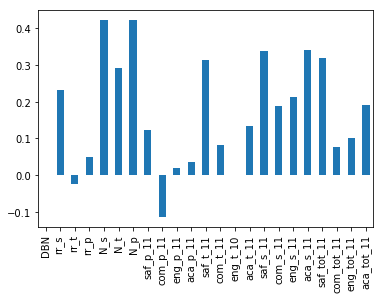

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

combined.corr()["sat_score"][survey_fields].plot.bar()

## Discussion

N_s, N_t, N_p are very highly correlated with sat_score, which makes sense since they are correlated with total_enrollment. 

rr_s (student response rate) is also highly correlated with sat_score, which can also make sense given that students are are more engaged in filling out the survey(and therefore completing administrative duties) may also be doing well academically.

saf_t_11, saft_s_11 (teachers' and students' perceived safety) also correlates with sat_score. One hypothesis is that those who feel safer are better able to learn and focus on education.

However, aca_s_11 (students' academic expectation) correlates with sat_score, while aca_t_11 (teachers') and aca_p_11 (parents') shows very weak correlations. This discrepancy may be due to the fact that sat scores, at the most fundamental level, are determined by the students' own performance, not how parents or teachers feel about the academic standards (although the latter two may strongly influence through both limiting/enabling factors).

## Investigating the safety scores

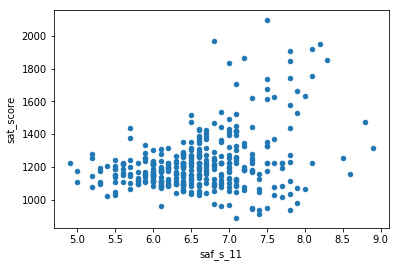

In [12]:
combined.plot.scatter("saf_s_11", "sat_score")

Students' perceived safety and their sat scores are correlated, although the correlation is not extremely strong. The school wwith the highest safety score did not demonstrate the highest sat score, and likewise, there are some schools with relatively lower safety scores that demonstrated some of the highest sat score. However, this is not to say that the two factors are uncorrelated, as no school with less than 6.5 safety score demonstrated an sat score higher than 1500.

## Map the safety scores of each district

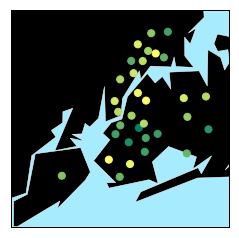

In [29]:
#get the aggregate of the mean values grouped by school district
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
district_safety = districts["saf_s_11"]

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#A7EBFF')
m.drawcoastlines(color='#FFFFFF', linewidth=.5)
m.drawrivers(color='#FFFFFF', linewidth=.5)
m.fillcontinents(color='#000000', lake_color='#A7EBFF')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=district_safety, cmap="summer")
plt.show()

From the map, it seems that lower Brooklyn, Bronx, and parts of Queens had lower safety scores, whereas Brooklyn and lower Manhattan had higher safety scores. 

## Investigating racial factors in SAT performance

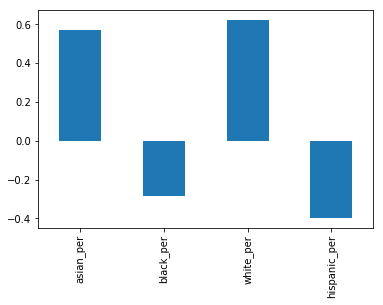

In [30]:
race_fields = ['asian_per', 'black_per', 'white_per', 'hispanic_per']

combined.corr()['sat_score'][race_fields].plot.bar()

From the bar plot, it seems that SAT scores are positively correlated with being of Asian or Caucasian ancestry, whereas the opposite is true for someone of Black or Hispanic origins. Those who identified as being Caucasian scored the higest on SAT exams. 

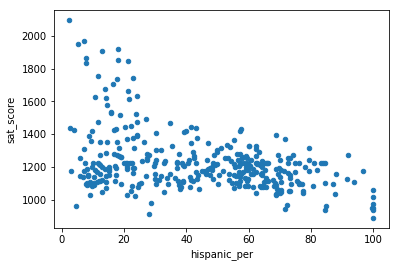

In [31]:
combined.plot.scatter('hispanic_per', 'sat_score')

There is a negatively-correlated relationship between hispanic_per and SAT score. Schools that had a high percentage of Hispanic students demonstrated some of the lowest SAT scores, whereas schools with the lowest percentage of Hispanic students had the highest SAT score.

In [40]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The listed schools tend to be geared towards recent immigrants to the US, meaning the students are English as Additional Language students. This would help explain the lower SAT scores.

In [41]:
print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above are specialized schools geared towards sciences. Admission is determined in part by the students' performance on an entrance exam, and this may help to explain why the same students performed well on SAT exams; they are academically high-achieving students. This, however, does not necessarily explain why such schools have lower percentage of Hispanic students.

## Investigating gender differences

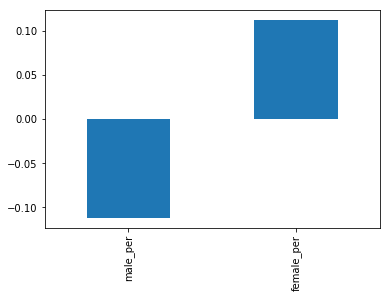

In [42]:
genders = ['male_per', 'female_per']
combined.corr()['sat_score'][genders].plot.bar()

Interestingly, our data tells us that schools with a larger number of female students performed better on SAT than schools with higher percentage of male students. However, both correlation scores are less than +/- 0.25, indicating that neither relationships are very strong.

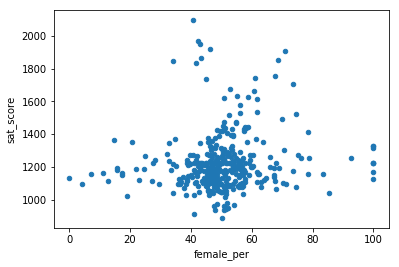

In [45]:
combined.plot.scatter('female_per', 'sat_score')

Based on the scatter plot, there is no meaningful relationship between the percentage of female students and SAT scores. However, there seems to be a cluster of schools with relatively higher SAT scores that had 60-80 percent range of female students.

In [47]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools seem to be selective institutions with high academic standards.

## Investigate AP exams vs SAT exams

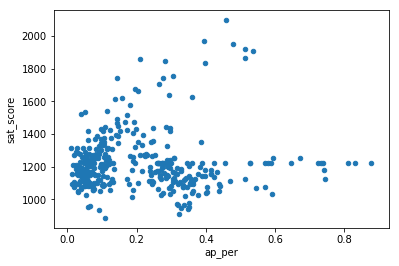

In [54]:
combined['ap_per'] = combined['AP Test Takers'] / combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')

From the scatter plot, it seems there is no meaningful relationship between the percentage of AP test takers and SAT scores of given schools. This conclusion is not definitive, however.